# Models to Predict Low Birth Weight
**Author: Jaclyn Dwyer**

**Project Goal**: To help Kaiser Permanente determine how to identify areas that need higher level NICUs, the goal of this project is to predict the percentage of low birth weight (LBW) births in California census tracts based off their population characteristics and environmental health hazards.

## Overview

Models are created in order to obtain the best predictions for percentage of LBW based off of population characteristics and environmental health hazards. The models are evaluated using RMSE score and R-Squared score. The RMSE score is used to gauge how concentrated the data is around the line of best fit and for the final model is used to determine how off the model is on average compared to the entire range of the target variable. The R-Squared score is used to capture how much variance the models are accounting for. Since a good R-Squared score is relative to the field being studied, a benchmark score is needed. According to [researchgate](https://www.researchgate.net/) an acceptable R-Sqaured score in the scientific community is above 0.5. Therefore, the goal for the final model is to get a low RMSE score and R-Squared score above 0.5.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
#read in data
df18 = pd.read_csv('data/merged/post_EDA_and_FE_df18')

#drop Unamed
df18.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

## Final Data Preparation

Some final data preparation is done before running the models including creating dummy variables from categorical features, renaming columns created from the dummy variables by changing letters to lowercase and getting rid of spaces, and dropping columns not wanted in the models.

In [3]:
df18.head(2)

,total_population,california_county,sb_535_disadvantaged,ozone,pm2_5,diesel_pm,drinking_water,pesticides,tox_release,traffic,cleanup_sites,groundwater_threats,haz_waste,imp_water_bodies,solid_waste,pollution_burden_score,lbw,education,linguistic_isolation,unemployment,housing_burden,Pop. Char. Score,less_10_yrs,yrs_11_64,greater_65,hispanic,white,african_american,native_american,asian_american,other,prev_ozone,prev_pm2_5,prev_diesel_pm,prev_drinking_water,prev_tox_release,prev_traffic,prev_groundwater_threats,prev_haz_waste,prev_imp_water_bodies,prev_solid_waste,prev_lbw,pm_breakdown,traffic_breakdown,cleanup_sites_breakdown,education_breakdown,hispanic_breakdown,white_breakdown,african_american_breakdown,asian_american_breakdown,smoking_prevalence
0,3174,Fresno,Yes,0.065,15.40,48.524,681.20,2.75,18551.957190,909.14,80.5,45.75,0.795,0,21.75,9.85,7.44,53.3,16.2,17.6,26.0,9.55,18.8,73.6,7.6,65.3,4.2,24.6,0.5,3.5,1.8,0.255228,14.746087,44.23,519.882370,96414.458370,1217.535680,55.75,0.520,0,5.0,5.80253,top,top,top,top,More,Less,More,Less,10.6
1,6133,San Bernardino,Yes,0.062,13.31,38.556,904.66,1.37,7494.236622,782.26,66.2,36.00,1.250,5,12.00,10.00,7.04,53.3,33.4,12.3,34.1,9.07,19.7,76.1,4.2,91.1,5.8,0.7,0.3,1.4,0.7,0.465401,13.888224,47.08,604.311803,8122.687693,1232.874128,49.00,1.845,5,2.0,6.38952,top,top,top,top,More,Less,Less,Less,13.5


In [4]:
#create dummy variables
cc_dummies = pd.get_dummies(df18['california_county'], prefix='cc', drop_first=True)
disadvantaged_dummies = pd.get_dummies(df18['sb_535_disadvantaged'], prefix='disadvantaged', drop_first=True)
pm_dummies = pd.get_dummies(df18['pm_breakdown'], prefix='pm_breakdown', drop_first=True)
traffic_breakdown_dummies = pd.get_dummies(df18['traffic_breakdown'], prefix='traffic_breakdown', drop_first=True)
cleanup_sites_breakdown_dummies = pd.get_dummies(df18['cleanup_sites_breakdown'], prefix='cleanup_sites_breakdown', drop_first=True)
education_breakdown_dummies = pd.get_dummies(df18['education_breakdown'], prefix='education_breakdown', drop_first=True)
hispanic_breakdown_dummies = pd.get_dummies(df18['hispanic_breakdown'], prefix='hispanic_breakdown', drop_first=True)
white_breakdown_dummies = pd.get_dummies(df18['white_breakdown'], prefix='white_breakdown', drop_first=True)
african_american_breakdown_dummies = pd.get_dummies(df18['african_american_breakdown'], prefix='african_american_breakdown', drop_first=True)
asian_american_breakdown_dummies = pd.get_dummies(df18['asian_american_breakdown'], prefix='asian_american_breakdown', drop_first=True)


df18 = pd.concat([df18, cc_dummies, disadvantaged_dummies, pm_dummies, traffic_breakdown_dummies, cleanup_sites_breakdown_dummies, 
                  education_breakdown_dummies, hispanic_breakdown_dummies, white_breakdown_dummies, 
                african_american_breakdown_dummies, asian_american_breakdown_dummies], axis=1)

In [5]:
#rename columns
df18.rename(columns = {'Pop. Char. Score': 'pop_char_score', 'cc_Amador ': 'cc_amador', 'cc_Butte ' : 'cc_butte', 
                       'cc_Calaveras ': 'cc_calaveras', 'cc_Colusa ': 'cc_colusa', 'cc_Contra Costa': 'cc_contra_costa', 
                       'cc_Del Norte': 'cc_del_norte', 'cc_El Dorado': 'cc_el_dorado', 'cc_Fresno ': 'cc_fresno', 
                       'cc_Glenn ': 'cc_glenn', 'cc_Humboldt ': 'cc_humboldt', 'cc_Imperial ': 'cc_imperial', 'cc_Inyo ': 'cc_inyo', 
                       'cc_Kern ': 'cc_kern', 'cc_Kings ': 'cc_kings', 'cc_Lake ': 'cc_lake', 'cc_Lassen ': 'cc_lassen', 
                       'cc_Los Angeles': 'cc_los_angeles', 'cc_Madera ': 'cc_madera', 'cc_Marin ': 'cc_marin', 
                       'cc_Mariposa ': 'cc_mariposa', 'cc_Mendocino ': 'cc_mendocino', 'cc_Merced ': 'cc_merced', 'cc_Mono ': 'cc_mono', 
                       'cc_Monterey ': 'cc_monterey', 'cc_Napa ': 'cc_napa', 'cc_Nevada ': 'cc_nevada', 'cc_Orange ': 'cc_orange', 
                       'cc_Placer ': 'cc_placer', 'cc_Plumas ': 'cc_plumas', 'cc_Riverside ': 'cc_riverside', 'cc_Sacramento ': 'cc_sacramento', 
                       'cc_San Benito': 'cc_san_benito', 'cc_San Bernardino': 'cc_san_bernardino', 
                       'cc_San Diego': 'cc_san_diego', 'cc_San Francisco': 'cc_san_francisco', 'cc_San Joaquin': 'cc_san_joaquin', 
                       'cc_San Luis Obispo': 'cc_san_luis_obispo', 'cc_San Mateo': 'cc_san_mateo', 
                       'cc_Santa Barbara': 'cc_santa_barbara', 'cc_Santa Clara': 'cc_santa_clara', 'cc_Santa Cruz': 'cc_santa_cruz', 
                       'cc_Shasta ': 'cc_shasta', 'cc_Sierra ': 'cc_sierra', 'cc_Siskiyou ': 'cc_siskiyou', 'cc_Solano ': 'cc_solano', 
                       'cc_Sonoma ': 'cc_sonoma', 'cc_Stanislaus ': 'cc_stanislaus', 'cc_Sutter ': 'cc_sutter', 'cc_Tehama ': 'cc_tehama', 
                       'cc_Trinity ': 'cc_trinity', 'cc_Tulare ': 'cc_tulare', 'cc_Tuolumne ': 'cc_tuolumne', 'cc_Ventura ': 'cc_ventura', 
                       'cc_Yolo ': 'cc_yolo', 'cc_Yuba ': 'cc_yuba'}, inplace = True)

In [6]:
#drop columns
df18.drop(columns = ['california_county', 'sb_535_disadvantaged', 
                     'pm_breakdown', 'traffic_breakdown', 'cleanup_sites_breakdown', 'education_breakdown', 
                     'hispanic_breakdown', 'white_breakdown', 'african_american_breakdown', 
                     'asian_american_breakdown', 
                     'pop_char_score'], axis = 1, inplace = True)

In [7]:
df18.head(2)

,total_population,ozone,pm2_5,diesel_pm,drinking_water,pesticides,tox_release,traffic,cleanup_sites,groundwater_threats,haz_waste,imp_water_bodies,solid_waste,pollution_burden_score,lbw,education,linguistic_isolation,unemployment,housing_burden,less_10_yrs,yrs_11_64,greater_65,hispanic,white,african_american,native_american,asian_american,other,prev_ozone,prev_pm2_5,prev_diesel_pm,prev_drinking_water,prev_tox_release,prev_traffic,prev_groundwater_threats,prev_haz_waste,prev_imp_water_bodies,prev_solid_waste,prev_lbw,smoking_prevalence,cc_amador,cc_butte,cc_calaveras,cc_colusa,cc_contra_costa,cc_del_norte,cc_el_dorado,cc_fresno,cc_glenn,cc_humboldt,...,cc_marin,cc_mariposa,cc_mendocino,cc_merced,cc_mono,cc_monterey,cc_napa,cc_nevada,cc_orange,cc_placer,cc_plumas,cc_riverside,cc_sacramento,cc_san_benito,cc_san_bernardino,cc_san_diego,cc_san_francisco,cc_san_joaquin,cc_san_luis_obispo,cc_san_mateo,cc_santa_barbara,cc_santa_clara,cc_santa_cruz,cc_shasta,cc_sierra,cc_siskiyou,cc_solano,cc_sonoma,cc_stanislaus,cc_sutter,cc_tehama,cc_trinity,cc_tulare,cc_tuolumne,cc_ventura,cc_yolo,cc_yuba,disadvantaged_Yes,pm_breakdown_middle,pm_breakdown_top,traffic_breakdown_middle,traffic_breakdown_top,cleanup_sites_breakdown_top,education_breakdown_lower_middle,education_breakdown_top,education_breakdown_upper_middle,hispanic_breakdown_More,white_breakdown_More,african_american_breakdown_More,asian_american_breakdown_More
0,3174,0.065,15.40,48.524,681.20,2.75,18551.957190,909.14,80.5,45.75,0.795,0,21.75,9.85,7.44,53.3,16.2,17.6,26.0,18.8,73.6,7.6,65.3,4.2,24.6,0.5,3.5,1.8,0.255228,14.746087,44.23,519.882370,96414.458370,1217.535680,55.75,0.520,0,5.0,5.80253,10.6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0
1,6133,0.062,13.31,38.556,904.66,1.37,7494.236622,782.26,66.2,36.00,1.250,5,12.00,10.00,7.04,53.3,33.4,12.3,34.1,19.7,76.1,4.2,91.1,5.8,0.7,0.3,1.4,0.7,0.465401,13.888224,47.08,604.311803,8122.687693,1232.874128,49.00,1.845,5,2.0,6.38952,13.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0,0,0


## Train Test Split

The data is split into two sets in order to train the model on one, test the model on the other, and evaluate the overall performance of the model. 

In [8]:
df18_features = df18.drop(columns = 'lbw', axis = 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df18_features, 
                                                    df18['lbw'], 
                                                    random_state=20, 
                                                    test_size=0.2)

## Baseline Model

A baseline model is created to start modeling.

In [10]:
#instantiate 
baseline = LinearRegression()

#fit 
baseline = baseline.fit(X_train, y_train)

In [11]:
#predict on sets
y_train_pred = baseline.predict(X_train)

y_test_pred = baseline.predict(X_test)

In [12]:
#rmse scores
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

In [13]:
#r-squared scores
r2 = r2_score(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)

In [14]:
print('baseline train: ' + str(rmse) + ', ' + 'rsquared: ' + str(r2))
print('baseline test: ' + str(rmse_test) + ', ' + 'rsquared: ' + str(r2_test))

baseline train: 0.992679838557695, rsquared: 0.5945651529055369
baseline test: 1.0018120881541097, rsquared: 0.5647889636400716


The results of the train and test RMSE are very similar not eliciting any concerns for overfitting when evaluated by RMSE. The model accounted for about 59% of the variance on the train set and about 56% on the test set.

## Interactions Model

### Create Interactions

To try a achieve a lower RMSE score, all possible interactions are created. Cross validations are used as well. If the interaction improves the score from the baseline model, the interaction is stored in an interactions list. 

In [ ]:
#create interactions
regression = LinearRegression()

X = df18.drop('lbw', axis=1)
y = df18['lbw']

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='neg_root_mean_squared_error', cv=crossvalidation))


interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='neg_root_mean_squared_error', cv=crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)

The interactions found above are added to the data set to use for modeling.

In [19]:
#function to create new column
def create_interaction(i, dataframe, interactions):
    new_column = interactions[i][0] + '_and_' + interactions[i][1]
    dataframe[new_column] = dataframe[interactions[i][0]] * dataframe[interactions[i][1]]

In [20]:
#add interactions to data set
for i in range(0,len(interactions)):
    create_interaction(i, df18, interactions)

### Train Test Split

A second train test split is conducted in order to include the interactions.

In [21]:
df18_features_i = df18.drop(columns = 'lbw', axis = 1)

In [22]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(df18_features_i, 
                                                    df18['lbw'], 
                                                    random_state=20, 
                                                    test_size=0.2)

### Create Interaction Model

In [23]:
#instantiate 
interactions = LinearRegression()

#fit 
interactions = interactions.fit(X_train_i, y_train_i)

In [24]:
#predict 
y_train_pred_i = interactions.predict(X_train_i)

y_test_pred_i = interactions.predict(X_test_i)

In [25]:
#rmse scores
mse_i = mean_squared_error(y_train_i, y_train_pred_i)
rmse_i = np.sqrt(mse_i)

mse_test_i = mean_squared_error(y_test_i, y_test_pred_i)
rmse_test_i = np.sqrt(mse_test_i)

In [26]:
#r-squared scores
r2_i = r2_score(y_train_i, y_train_pred_i)

r2_test_i = r2_score(y_test_i, y_test_pred_i)

In [27]:
print('baseline train: ' + str(rmse) + ', ' + 'rsquared: ' + str(r2))
print('baseline test: ' + str(rmse_test) + ', ' + 'rsquared: ' + str(r2_test))
print('interactions train: ' + str(rmse_i) + ', ' + 'rsquared: ' + str(r2_i))
print('interactions test: ' + str(rmse_test_i) + ', ' + 'rsquared: ' + str(r2_test_i))

baseline train: 0.992679838557695, rsquared: 0.5945651529055369
baseline test: 1.0018120881541097, rsquared: 0.5647889636400716
interactions train: 0.8294342010117169, rsquared: 0.7169477906729933
interactions test: 1.116289329005952, rsquared: 0.45964283943559303


Adding the interactions resulted in a lowered RMSE score and higher R-Squared score for the train set. However, the RMSE of the test set increased and the R-Squared for the test set decreased, indicating that the model is overfitted. In order to try and account for overfitting some features are dropped using feature elimination techniques.

## Select K Best Model

Select K best is used in order to try and eliminate some features to account for overfitting and create improved predictions. This model was previously run with a k equal to 50, 75, 100, 150, 200, and 300 in order to obtain the best train and test scores. The results are shown in the graph below.

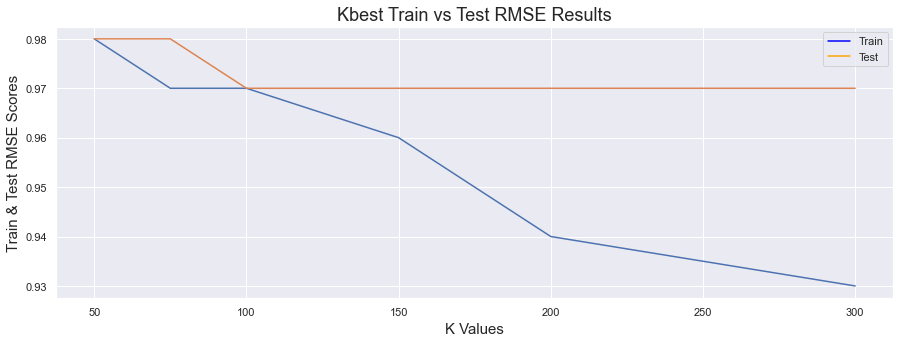

In [28]:
#plot graph
f, axes = plt.subplots(1, figsize=(15,5))
line = sns.lineplot(x= [50, 75, 100, 150, 200, 300],
                    y=[0.98, 0.97, 0.97, 0.96, 0.94, 0.93])
line2 = sns.lineplot(x= [50, 75, 100, 150, 200, 300],
                    y=[0.98, 0.98, 0.97, 0.97, 0.97, 0.97])
line.axes.set_title("Kbest Train vs Test RMSE Results",fontsize=18)
line.set_xlabel("K Values",fontsize=15)
line.set_ylabel("Train & Test RMSE Scores",fontsize=15)

#create proxy artist legent
blue_line = mlines.Line2D([], [], color='blue', label='Train')
orange_line = mlines.Line2D([], [], color='orange', label='Test')
line.legend(handles=[blue_line, orange_line]);

Looking at the graph above, the best k value to use for RMSE scores seems to be 100. The k values less than 100 had higher RMSE scores and k values over 100 started indicating the model may be overfitting. The graph for the R-Squared values are plotted below.

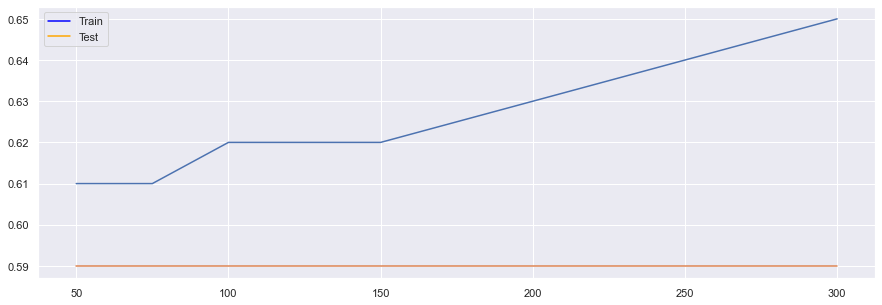

In [29]:

f, axes = plt.subplots(1, figsize=(15,5))

line3 = sns.lineplot(x= [50, 75, 100, 150, 200, 300],
                    y=[0.61, 0.61, 0.62, 0.62, 0.63, 0.65])
line4 = sns.lineplot(x= [50, 75, 100, 150, 200, 300],
                    y=[0.59, 0.59, 0.59, 0.59, 0.59, 0.59])
line.axes.set_title("Kbest Train vs Test R-Squared Results",fontsize=18)
line.set_xlabel("K Values",fontsize=15)
line.set_ylabel("Train & Test R-Squared Scores",fontsize=15)
#create proxy artist legent
blue_line = mlines.Line2D([], [], color='blue', label='Train')
orange_line = mlines.Line2D([], [], color='orange', label='Test')
line3.legend(handles=[blue_line, orange_line]);

Since the best k value for RMSE was 100, looking at the R-Squared scores for a k value of 100 does support choosing a k value of 100. A k value less than 100 has a tiny bit of a better R-squared, however only by 0.01, so a k value of 100 is okay to choose. A k value more that 100 (besides 150) starts to lead to a higher R-Squared for the the train set which can indicate overfitting. Therefore, a k value of 100 is chosen.

In [30]:
#istantiate
selector = SelectKBest(f_regression, k=100)

#fit
selector.fit(X_train_i, y_train_i)

/Users/jaclynhenn/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


SelectKBest(k=100, score_func=<function f_regression at 0x7f91778f13a0>)

In [31]:
selector.get_support();

In [32]:
#get selected and removed columns
selected_k_columns = X_train_i.columns[selector.get_support()]
removed_k_columns = X_train_i.columns[~selector.get_support()]

#istantiate
kbest = LinearRegression()

#fit 
kbest = kbest.fit(X_train_i[selected_k_columns], y_train_i)

In [33]:
#predict on train and test set
y_train_pred_k = kbest.predict(X_train_i[selected_k_columns])

y_test_pred_k = kbest.predict(X_test_i[selected_k_columns])

In [34]:
#rmse scores
mse_k = mean_squared_error(y_train_i, y_train_pred_k)
rmse_k = np.sqrt(mse_k)

mse_test_k = mean_squared_error(y_test_i, y_test_pred_k)
rmse_test_k = np.sqrt(mse_test_k)

In [35]:
#give true value and predictions
r2_k = r2_score(y_train_i, y_train_pred_k)

r2_test_k = r2_score(y_test_i, y_test_pred_k)

In [36]:
print('baseline train: ' + str(rmse) + ', ' + 'rsquared: ' + str(r2))
print('baseline test: ' + str(rmse_test) + ', ' + 'rsquared: ' + str(r2_test))
print('interactions train: ' + str(rmse_i) + ', ' + 'rsquared: ' + str(r2_i))
print('interactions test: ' + str(rmse_test_i) + ', ' + 'rsquared: ' + str(r2_test_i))
print('kbest train: ' + str(rmse_k) + ', ' + 'rsquared: ' + str(r2_k))
print('kbest test: ' + str(rmse_test_k) + ', ' + 'rsquared: ' + str(r2_test_k))

baseline train: 0.992679838557695, rsquared: 0.5945651529055369
baseline test: 1.0018120881541097, rsquared: 0.5647889636400716
interactions train: 0.8294342010117169, rsquared: 0.7169477906729933
interactions test: 1.116289329005952, rsquared: 0.45964283943559303
kbest train: 0.9655497462605852, rsquared: 0.616423511656868
kbest test: 0.9742428708851975, rsquared: 0.5884128214391924


The results from the Kbest model show a decrease in the RMSE score compared to the baseline model and do not show as much signs of overfitting as seen in the interactions model, making the Kbest model the preferred model.

## Recursive Feature Elimination (RFE)

One more feature elimination technique is run on the features selected in the kbest model.
A best subset of features is created by a process of eliminating underperforming features of a model one by one.

In [37]:
#istantiate
ols = LinearRegression()

# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=7,  scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# Fit  
selector.fit(X_train_i[selected_k_columns], y_train)

Fitting estimator with 100 features.
Fitting estimator with 99 features.


RFECV(cv=7, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_root_mean_squared_error', verbose=1)

In [38]:
#get selected and removed
selected_rfe = X_train_i[selected_k_columns].columns[selector.support_]
removed_rfe = X_train_i[selected_k_columns].columns[~selector.support_]

In [39]:
#instantiate
rfe = LinearRegression()

#fit 
rfe = rfe.fit(X_train_i[selected_rfe], y_train_i)

In [40]:
#predict
y_train_pred_rfe = rfe.predict(X_train_i[selected_rfe])

y_test_pred_rfe = rfe.predict(X_test_i[selected_rfe])

In [41]:
#rmse score
mse_rfe = mean_squared_error(y_train_i, y_train_pred_rfe)
rmse_rfe = np.sqrt(mse_rfe)

mse_test_rfe = mean_squared_error(y_test_i, y_test_pred_rfe)
rmse_test_rfe = np.sqrt(mse_test_rfe)

In [42]:
#r-squared score
r2_rfe = r2_score(y_train_i, y_train_pred_rfe)

r2_test_rfe = r2_score(y_test_i, y_test_pred_rfe)

In [43]:
print('baseline train: ' + str(rmse) + ', ' + 'rsquared: ' + str(r2))
print('baseline test: ' + str(rmse_test) + ', ' + 'rsquared: ' + str(r2_test))
print('interactions train: ' + str(rmse_i) + ', ' + 'rsquared: ' + str(r2_i))
print('interactions test: ' + str(rmse_test_i) + ', ' + 'rsquared: ' + str(r2_test_i))
print('kbest train: ' + str(rmse_k) + ', ' + 'rsquared: ' + str(r2_k))
print('kbest test: ' + str(rmse_test_k) + ', ' + 'rsquared: ' + str(r2_test_k))
print('rfe train: ' + str(rmse_rfe) + ', ' + 'rsquared: ' + str(r2_rfe))
print('rfe test: ' + str(rmse_test_rfe) + ', ' + 'rsquared: ' + str(r2_test_rfe))

baseline train: 0.992679838557695, rsquared: 0.5945651529055369
baseline test: 1.0018120881541097, rsquared: 0.5647889636400716
interactions train: 0.8294342010117169, rsquared: 0.7169477906729933
interactions test: 1.116289329005952, rsquared: 0.45964283943559303
kbest train: 0.9655497462605852, rsquared: 0.616423511656868
kbest test: 0.9742428708851975, rsquared: 0.5884128214391924
rfe train: 0.9656882744676683, rsquared: 0.6163134397001213
rfe test: 0.9746467059427252, rsquared: 0.5880715353275165


The Kbest model and RFE model are extremely similar, however, the RFE model very slightly improved the model by decreasing the difference in the train and test sets. Therefore, the RFE model is preferred.

## GridSearch Random Forest Model

A random forest model is run with parameters found using GridSearch.

In [45]:
#instantiate
forest = RandomForestRegressor(random_state = 20)

In [46]:
#create custom scorer for RMSE
custom_scorer = 'neg_root_mean_squared_error'

In [47]:
#get dict of params
rf_param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200, 300],
    'random_state': [0],
}

#instantiate  
forest_grid_search = GridSearchCV(estimator = forest, param_grid = rf_param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = custom_scorer)

In [48]:
#fit 
forest_grid_search.fit(X_train_i[selected_rfe], y_train_i)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.4min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=20), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 200, 300],
                         'random_state': [0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [49]:
#instantiate with best params model
gs_forest = forest_grid_search.best_estimator_

In [50]:
#fit with best params model
gs_forest.fit(X_train_i[selected_rfe], y_train_i)

RandomForestRegressor(max_depth=10, max_features=3, min_samples_leaf=4,
                      min_samples_split=10, n_estimators=300, random_state=0)

In [51]:
#predict 
y_train_pred_gsrf = gs_forest.predict(X_train_i[selected_rfe])

y_test_pred_gsrf = gs_forest.predict(X_test_i[selected_rfe])

In [52]:
#rmse score
mse_gsrf = mean_squared_error(y_train_i, y_train_pred_gsrf)
rmse_gsrf = np.sqrt(mse_gsrf)

mse_test_gsrf = mean_squared_error(y_test_i, y_test_pred_gsrf)
rmse_test_gsrf = np.sqrt(mse_test_gsrf)

In [53]:
#r-square score
r2_gsrf = r2_score(y_train_i, y_train_pred_gsrf)

r2_test_gsrf = r2_score(y_test_i, y_test_pred_gsrf)

In [54]:
print('baseline train: ' + str(rmse) + ', ' + 'rsquared: ' + str(r2))
print('baseline test: ' + str(rmse_test) + ', ' + 'rsquared: ' + str(r2_test))
print('interactions train: ' + str(rmse_i) + ', ' + 'rsquared: ' + str(r2_i))
print('interactions test: ' + str(rmse_test_i) + ', ' + 'rsquared: ' + str(r2_test_i))
print('kbest train: ' + str(rmse_k) + ', ' + 'rsquared: ' + str(r2_k))
print('kbest test: ' + str(rmse_test_k) + ', ' + 'rsquared: ' + str(r2_test_k))
print('rfe train: ' + str(rmse_rfe) + ', ' + 'rsquared: ' + str(r2_rfe))
print('rfe test: ' + str(rmse_test_rfe) + ', ' + 'rsquared: ' + str(r2_test_rfe))
print('gridsearch rf train: ' + str(rmse_gsrf) + ', ' + 'rsquared: ' + str(r2_gsrf))
print('gridsearch rf test: ' + str(rmse_test_gsrf) + ', ' + 'rsquared: ' + str(r2_test_gsrf))

baseline train: 0.992679838557695, rsquared: 0.5945651529055369
baseline test: 1.0018120881541097, rsquared: 0.5647889636400716
interactions train: 0.8294342010117169, rsquared: 0.7169477906729933
interactions test: 1.116289329005952, rsquared: 0.45964283943559303
kbest train: 0.9655497462605852, rsquared: 0.616423511656868
kbest test: 0.9742428708851975, rsquared: 0.5884128214391924
rfe train: 0.9656882744676683, rsquared: 0.6163134397001213
rfe test: 0.9746467059427252, rsquared: 0.5880715353275165
gridsearch rf train: 0.9320045338563372, rsquared: 0.6426130247799028
gridsearch rf test: 1.0754258142729094, rsquared: 0.49847997500804464


With the random forest model created with gridsearch both the train scores improved but both the test scores declined, indicating overfitting. Therefore, the RFE model is the preferred model.

## Final Model

The model with the most similar test and train scores, low RMSE scores, and high R-Squared scores is the RFE model. The model is further evaluated below.

### Check Assumptions

Homoscedasticity is checked below by plotting the residuals. The graph appears to be homoscedastic.

/Users/jaclynhenn/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


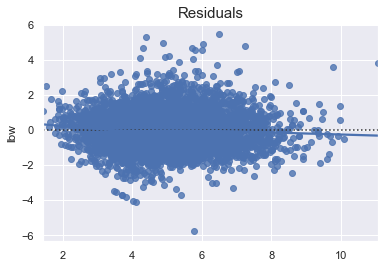

In [100]:
#Plot Residuals
f, axes = plt.subplots(1)
rs = sns.residplot(y_train_pred_rfe, y_train_i, lowess=True, color="b")
rs.axes.set_title("Residuals",fontsize=15);

A histogram of residuals is plotted below to check normality. The residuals appear to follow a normal distribution.

/Users/jaclynhenn/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jaclynhenn/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


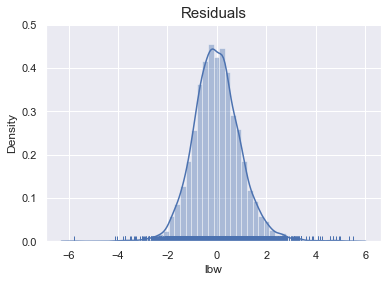

In [99]:
#Plot Residuals
residuals_2 =  y_train_i - y_train_pred_rfe

f, axes = plt.subplots(1)
hs = sns.distplot(residuals_2, kde=True, rug=True)
hs.axes.set_title("Residuals",fontsize=15);

### Evaluate RMSE Score

To evaluate the RMSE score the score is used to determine how off the model is on average compared to the entire range of the target variable by looking at the min and max of LBW. 

In [83]:
0.9656882744676683 / (y_train_i.max() - y_train_i.min())

0.06485482031347671

The results indicate a good RMSE score.

### Selected RFE

The features which made it into the final model are viewed below. 

In [62]:
selected_rfe

Index(['education', 'unemployment', 'housing_burden', 'white',
       'african_american', 'prev_lbw', 'disadvantaged_Yes',
       'white_breakdown_More', 'african_american_breakdown_More',
       'total_population_and_african_american',
       'total_population_and_disadvantaged_Yes',
       'total_population_and_white_breakdown_More', 'ozone_and_education',
       'ozone_and_housing_burden', 'ozone_and_white',
       'ozone_and_african_american', 'ozone_and_prev_lbw',
       'ozone_and_disadvantaged_Yes', 'ozone_and_white_breakdown_More',
       'ozone_and_african_american_breakdown_More', 'pm2_5_and_education',
       'pm2_5_and_housing_burden', 'pm2_5_and_white',
       'pm2_5_and_african_american', 'pm2_5_and_prev_lbw',
       'pm2_5_and_hispanic_breakdown_More', 'pm2_5_and_white_breakdown_More',
       'pm2_5_and_african_american_breakdown_More',
       'diesel_pm_and_disadvantaged_Yes',
       'pollution_burden_score_and_education',
       'pollution_burden_score_and_housing_burd

Both population characteristics as well as environmental health hazards features are seen in the selected RFE features. 

### Significant Features

An ols model is created using the selected RFE. The summary table is visualized in order to determine which features were considered significant for predictions.

In [77]:
#reset ols
ols = None

In [ ]:
#import statsmodels
import statsmodels.formula.api as sm

In [79]:
#create ols model
outcome = 'lbw'
predictors = df18[selected_rfe]
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

model = sm.ols(formula=formula, data=df18).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lbw   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     128.4
Date:                Wed, 05 May 2021   Prob (F-statistic):               0.00
Time:                        14:55:19   Log-Likelihood:                -10811.
No. Observations:                7812   AIC:                         2.181e+04
Df Residuals:                    7716   BIC:                         2.248e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -6.2044      0.886     -7.006      0.000      -7.940      -4.468
education                                                       0.0784      0.028      2.818      0.005       0.024       0.133
unemployment                                                   -0.0327      0.035     -0.929      0.353      -0.102       0.036
housing_burden                                                  0.0209      0.026      0.791      0.429      -0.031       0.073
white                                                       -3.107e-05   6.09e-06     -5.103      0.000    -4.3e-05   -1.91e-05
african_american                                                0.0206      0.037      0.562      0.574      -0.051       0.093
prev_lbw                                                        2.5601      0.192     13.365      0.000       2.185       2.936
disadvantaged_Yes                                              -0.0003      0.000     -1.489      0.136      -0.001       0.000
white_breakdown_More                                           -0.0001      0.000     -0.390      0.697      -0.001       0.000
african_american_breakdown_More                                 1.7621      0.432      4.081      0.000       0.916       2.609
total_population_and_african_american                       -3.884e-06   7.19e-07     -5.402      0.000   -5.29e-06   -2.47e-06
total_population_and_disadvantaged_Yes                       -3.95e-05   1.41e-05     -2.807      0.005   -6.71e-05   -1.19e-05
total_population_and_white_breakdown_More                    8.582e-05    9.2e-06      9.327      0.000    6.78e-05       0.000
ozone_and_education                                             0.3465      0.180      1.922      0.055      -0.007       0.700
ozone_and_housing_burden                                        0.0135      0.200      0.067      0.946      -0.379       0.406
ozone_and_white                                                 0.3325      0.136      2.446      0.014       0.066       0.599
ozone_and_african_american                                      0.6908      0.300      2.299      0.022       0.102       1.280
ozone_and_prev_lbw                                             -3.4215      1.703     -2.009      0.045      -6.761      -0.082
ozone_and_disadvantaged_Yes                                     9.1145      4.405      2.069      0.039       0.479      17.750
ozone_and_white_breakdown_More                                 -0.5293      5.980     -0.089      0.929     -12.252      11.193
ozone_and_african_american_breakdown_More                      -5.5504      3.241     -1.712      0.087     -11.904       0.803
pm2_5_and_e

Looking at the summary shows that the significant features for preditions (those with a p-value less than 0.05) are mostly interactions that include population characteristics and enivornmental health hazards. However, population characteristics appear much more than environmental health hazard features in the significant features. Indicating that population characteristics might be more impactful for predicting LBW percentages by California census tract.

## Summary

The RFE model is deemed the best model due to its lower RMSE score and higher R-Squared score. That makes it the best model for predicting LBW percentages for California census tracts based off of population characteristics and environmental health hazards. Future steps for modeling include creating a gradient boost tree or XGBoost model in order to see if a model with lower RMSE and higher R-Squared scores can be obtained.

## Next Steps

Future steps to improve this project include:
  - Adding in clustering
  - Running gradient tree boosting and XGBoost models to see if better predictions are achieved
  - Creating a causal inference model
  - Designing a Streamlit app